## Data Ingestion

In [10]:
import numpy as np
import pandas as pd

RANDOM_STATE = 42

df = pd.read_csv("data.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)

if "SeniorCitizen" in df.columns:
    df["SeniorCitizen"] = df["SeniorCitizen"].astype("category")

df[["Churn"]].value_counts()


Churn
0        5174
1        1869
Name: count, dtype: int64

In [ ]:
y = df["Churn"]
X = df.drop(columns=["Churn"])


((7043, 19), np.float64(0.2653698707936959))

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "churn rate:", y_train.mean())
print("Test: ", X_test.shape,  "churn rate:", y_test.mean())


Train: (5634, 19) churn rate: 0.2653532126375577
Test:  (1409, 19) churn rate: 0.2654364797728886


In [6]:
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)


Numeric: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols)
])


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(model, X, y, name):
    y_pred = model.predict(X)
    print(f"\n{name}")
    print("Accuracy :", accuracy_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall   :", recall_score(y, y_pred))
    print("F1       :", f1_score(y, y_pred))


## Baseline Models

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

logreg = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

In [31]:
logreg.fit(X_train, y_train)
evaluate(logreg, X_test, y_test, "Logistic Regression")


Logistic Regression
Accuracy : 0.7374024130589071
Precision: 0.5034364261168385
Recall   : 0.7834224598930482
F1       : 0.6129707112970711


In [32]:
from sklearn.tree import DecisionTreeClassifier

dt = Pipeline([
    ("prep", preprocessor),
    ("model", DecisionTreeClassifier(
        max_depth=None,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

dt.fit(X_train, y_train)
evaluate(dt, X_test, y_test, "Decision Tree")

In [33]:
dt.fit(X_train, y_train)
evaluate(dt, X_test, y_test, "Decision Tree")


Decision Tree
Accuracy : 0.7310149041873669
Precision: 0.49295774647887325
Recall   : 0.4679144385026738
F1       : 0.48010973936899864


In [34]:
from sklearn.svm import SVC

svc = Pipeline([
    ("prep", preprocessor),
    ("model", SVC(
        kernel="linear",
        class_weight="balanced",
        probability=False,
        random_state=RANDOM_STATE
    ))
])


In [35]:
svc.fit(X_train, y_train)
evaluate(svc, X_test, y_test, "Linear SVC")


Linear SVC
Accuracy : 0.6941092973740242
Precision: 0.45752608047690013
Recall   : 0.820855614973262
F1       : 0.5875598086124402


In [ ]:
from sklearn.naive_bayes import GaussianNB

X_train_nb = preprocessor.fit_transform(X_train)
X_test_nb  = preprocessor.transform(X_test)

gnb = GaussianNB()


Gaussian Naive Bayes
Accuracy : 0.6955287437899219
Precision: 0.45973645680819913
Recall   : 0.839572192513369
F1       : 0.5941343424787133


In [ ]:
gnb.fit(X_train_nb, y_train)
evaluate(gnb, X_test_nb, y_test, "Gaussian Naive Bayes")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

n = 50

knn = Pipeline([
    ("prep", preprocessor),
    ("model", KNeighborsClassifier(n_neighbors=n))
])

In [ ]:
knn.fit(X_train, y_train)
evaluate(knn, X_test, y_test, f"k-NN (k={n})")


k-NN (k=50)
Accuracy : 0.78708303761533
Precision: 0.6027777777777777
Recall   : 0.5802139037433155
F1       : 0.5912806539509536


In [ ]:
from rulefit import RuleFit
from sklearn.ensemble import RandomForestClassifier

rf_base = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    random_state=RANDOM_STATE
)

rulefit = RuleFit(
    tree_generator=rf_base,
    rfmode='classify'
)

X_train_rf = preprocessor.fit_transform(X_train)
X_test_rf  = preprocessor.transform(X_test)

KeyboardInterrupt: 

In [ ]:
rulefit.fit(X_train_rf, y_train)
evaluate(rulefit, X_test_rf, y_test, "RuleFit")

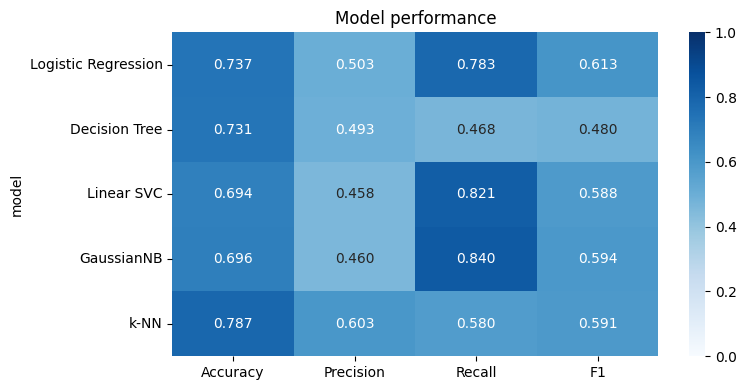

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": (logreg, X_test),
    "Decision Tree": (dt, X_test),
    "Linear SVC": (svc, X_test),
    "GaussianNB": (gnb, X_test_nb),
    "k-NN": (knn, X_test),
}

metric_funcs = {
    "Accuracy": accuracy_score,
    "Precision": lambda y_true, y_pred: precision_score(y_true, y_pred, zero_division=0),
    "Recall": lambda y_true, y_pred: recall_score(y_true, y_pred, zero_division=0),
    "F1": lambda y_true, y_pred: f1_score(y_true, y_pred, zero_division=0)
}

rows = []
for name, (model, X_in) in models.items():
    y_pred = model.predict(X_in)
    scores = {m: func(y_test, y_pred) for m, func in metric_funcs.items()}
    scores["model"] = name
    rows.append(scores)

df_scores = pd.DataFrame(rows).set_index("model")

plt.figure(figsize=(8, 4))
sns.heatmap(df_scores, annot=True, fmt=".3f", cmap="Blues", vmin=0, vmax=1)
plt.title("Model performance")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Baseline Models with CV

In [41]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=RANDOM_STATE
)


In [ ]:
from sklearn.model_selection import cross_validate

def cv_evaluate(model, X, y, name):
    scores = cross_validate(
        model,
        X,
        y,
        cv=skf,
        scoring=["accuracy", "precision", "recall", "f1"],
        n_jobs=-1
    )
    
    print(f"\n{name}")
    print("Accuracy :", scores["test_accuracy"].mean())
    print("Precision:", scores["test_precision"].mean())
    print("Recall   :", scores["test_recall"].mean())
    print("F1       :", scores["test_f1"].mean())


In [ ]:
cv_evaluate(
    logreg,
    X_train,
    y_train,
    "Logistic Regression CV"
)


Logistic Regression CV
Accuracy : 0.7493817945907814
Precision: 0.518308753916846
Recall   : 0.8027248322147651
F1       : 0.6296368752396806


In [ ]:
cv_evaluate(
    dt,
    X_train,
    y_train,
    "Decision Tree CV"
)


Decision Tree CV
Accuracy : 0.7366054444906341
Precision: 0.5041923924641152
Recall   : 0.48970022371364647
F1       : 0.49620510644124405


In [ ]:
cv_evaluate(
    dt,
    X_train,
    y_train,
    "Decision Tree CV"
)


Decision Tree CV
Accuracy : 0.7366054444906341
Precision: 0.5041923924641152
Recall   : 0.48970022371364647
F1       : 0.49620510644124405


In [ ]:
cv_evaluate(
    knn,
    X_train,
    y_train,
    "k-NN (n=50) CV"
)


k-NN (n=50) CV
Accuracy : 0.7974840331053248
Precision: 0.6343827301681717
Recall   : 0.5632662192393736
F1       : 0.5958038627910669


In [ ]:
from sklearn.model_selection import cross_val_score

X_train_nb = preprocessor.fit_transform(X_train)

gnb_r = cross_val_score(
    GaussianNB(),
    X_train_nb,
    y_train,
    cv=skf,
    scoring="recall"
)

print("\nGaussian Naive Bayes CV")
print("Recall:", gnb_r.mean())


Gaussian Naive Bayes CV
Recall: 0.8455078299776286


,Accuracy,Precision,Recall,F1
Model,,,,
Logistic Regression,0.749382,0.518309,0.802725,0.629637
Decision Tree,0.736605,0.504192,0.489700,0.496205
Linear SVC,0.702340,0.466382,0.835477,0.598381
GaussianNB,0.696305,0.461156,0.845508,0.596544
k-NN,0.797484,0.634383,0.563266,0.595804


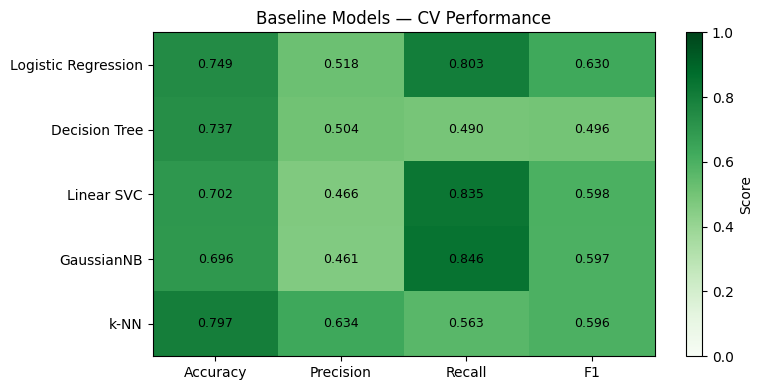

In [ ]:
from sklearn.preprocessing import FunctionTransformer

to_dense = FunctionTransformer(lambda X: X.toarray() if hasattr(X, "toarray") else X)

gnb_pipeline = Pipeline([
    ("prep", preprocessor),
    ("dense", to_dense),
    ("model", GaussianNB())
])

models_cv = {
    "Logistic Regression": logreg,
    "Decision Tree": dt,
    "Linear SVC": svc,
    "GaussianNB": gnb_pipeline,
    "k-NN": knn,
}

rows = []
for name, model in models_cv.items():
    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=skf,
        scoring=["accuracy", "precision", "recall", "f1"],
        n_jobs=-1
    )
    rows.append({
        "Model": name,
        "Accuracy": scores["test_accuracy"].mean(),
        "Precision": scores["test_precision"].mean(),
        "Recall": scores["test_recall"].mean(),
        "F1": scores["test_f1"].mean()
    })

df_cv = pd.DataFrame(rows).set_index("Model")
display(df_cv)


plt.figure(figsize=(8, 4))
plt.imshow(df_cv.values, aspect="auto", vmin=0, vmax=1, cmap="Greens")
plt.colorbar(label="Score")

plt.xticks(range(df_cv.shape[1]), df_cv.columns, rotation=0)
plt.yticks(range(df_cv.shape[0]), df_cv.index)

for i in range(df_cv.shape[0]):
    for j in range(df_cv.shape[1]):
        plt.text(j, i, f"{df_cv.values[i, j]:.3f}", ha="center", va="center", fontsize=9)

plt.title("Baseline Models — CV Performance")
plt.tight_layout()
plt.show()

## Improvement over Baseline after CV

In [ ]:
common_models = df_scores.index.intersection(df_cv.index)
df_test_aligned = df_scores.loc[common_models]
df_cv_aligned   = df_cv.loc[common_models]
df_test_aligned = df_test_aligned[df_cv_aligned.columns]

In [ ]:
df_diff = df_cv_aligned - df_test_aligned
display(df_diff)

,Accuracy,Precision,Recall,F1
Logistic Regression,0.011979,0.014872,0.019302,0.016666
Decision Tree,0.005591,0.011235,0.021786,0.016095
Linear SVC,0.008231,0.008856,0.014621,0.010822
GaussianNB,0.000776,0.001420,0.005936,0.002409
k-NN,0.010401,0.031605,-0.016948,0.004523


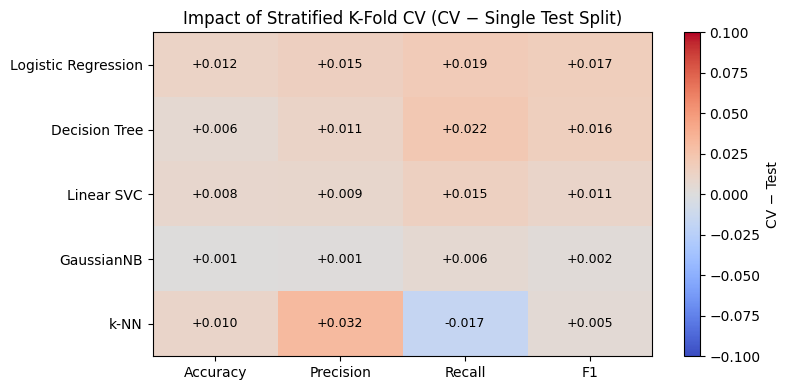

In [ ]:
plt.figure(figsize=(8, 4))
plt.imshow(df_diff.values, aspect="auto", cmap="coolwarm", vmin=-0.1, vmax=0.1)
plt.colorbar(label="CV − Test")

plt.xticks(range(df_diff.shape[1]), df_diff.columns)
plt.yticks(range(df_diff.shape[0]), df_diff.index)

# Annotate cells
for i in range(df_diff.shape[0]):
    for j in range(df_diff.shape[1]):
        plt.text(j, i, f"{df_diff.values[i, j]:+.3f}",
                 ha="center", va="center", fontsize=9)

plt.title("Impact of Stratified K-Fold CV (CV − Single Test Split)")
plt.tight_layout()
plt.show()

## Hyper-Parameter Tuning for Baseline

In [ ]:
from sklearn.model_selection import GridSearchCV

logreg_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

C_grid = np.logspace(-4, 4, 17)

logreg_param_grid = [
    # liblinear: l1/l2 only
    {
        "model__solver": ["liblinear"],
        "model__penalty": ["l1", "l2"],
        "model__C": C_grid,
        "model__max_iter": [2000],
        "model__tol": [1e-4, 1e-3],
    },
    # lbfgs: l2 only
    {
        "model__solver": ["lbfgs"],
        "model__penalty": ["l2"],
        "model__C": C_grid,
        "model__max_iter": [2000],
        "model__tol": [1e-4, 1e-3],
    },
    # saga: l1/l2/elasticnet
    {
        "model__solver": ["saga"],
        "model__penalty": ["l1", "l2"],
        "model__C": C_grid,
        "model__max_iter": [3000],
        "model__tol": [1e-4, 1e-3],
    },
    {
        "model__solver": ["saga"],
        "model__penalty": ["elasticnet"],
        "model__C": C_grid,
        "model__l1_ratio": [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95],
        "model__max_iter": [5000],
        "model__tol": [1e-4, 1e-3],
    },
]

logreg_gs = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=logreg_param_grid,
    scoring="recall",
    cv=skf,
    n_jobs=-1,
    refit=True
)

logreg_gs.fit(X_train, y_train)

print("Best CV Recall:", logreg_gs.best_score_)
print("Best hyperparameters:")
print(logreg_gs.best_params_)

Best CV Recall: 0.8461744966442953
Best hyperparameters:
{'model__C': np.float64(0.0001), 'model__max_iter': 2000, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'model__tol': 0.0001}


In [ ]:
best_logreg = logreg_pipe.set_params(**logreg_gs.best_params_)
best_logreg.fit(X_train, y_train)
y_pred = best_logreg.predict(X_test)

print("F1       :", f1_score(y_test, y_pred, zero_division=0))
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))


F1       : 0.5870178739416745
Accuracy : 0.6884315117104329
Precision: 0.4528301886792453
Recall   : 0.8342245989304813


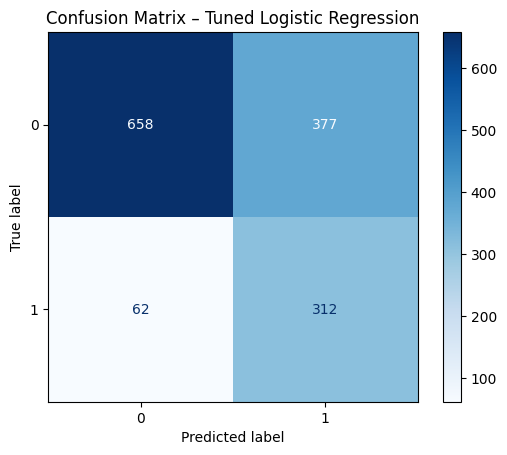

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_logreg = logreg_gs.best_estimator_
y_pred = best_logreg.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=best_logreg.classes_
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Tuned Logistic Regression")
plt.show()


Logistic Regression (final tuned model)
Accuracy : 0.6884315117104329
Precision: 0.4528301886792453
Recall   : 0.8342245989304813
F1       : 0.5870178739416745


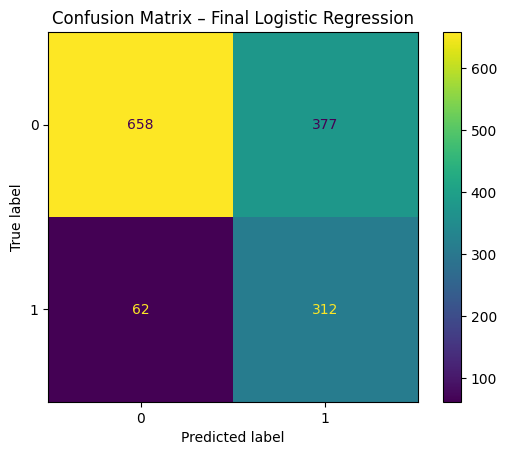

In [ ]:
logreg_final = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(
        C=0.0001,
        penalty="l2",
        solver="liblinear",
        max_iter=2000,
        tol=0.0001,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])


logreg_final.fit(X_train, y_train)
y_pred = logreg_final.predict(X_test)

print("Logistic Regression (final tuned model)")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1       :", f1_score(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_final.classes_)
disp.plot(values_format="d")
plt.title("Confusion Matrix – Final Logistic Regression")
plt.show()


Decision Tree (tuned with CV)
Best CV F1: 0.6201465179506093
Best params: {'model__ccp_alpha': 0.001, 'model__criterion': 'gini', 'model__max_depth': 12, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 20, 'model__splitter': 'best'}

Test scores
Accuracy : 0.7210787792760823
Precision: 0.4843492586490939
Recall   : 0.786096256684492
F1       : 0.599388379204893


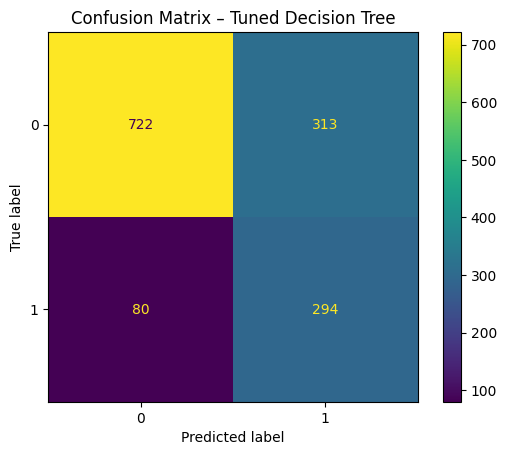

In [ ]:
dt_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", DecisionTreeClassifier(
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

dt_param_grid = {
    "model__criterion": ["gini", "entropy", "log_loss"],
    "model__splitter": ["best", "random"],
    "model__max_depth": [3, 5, 8, 12, 16],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5, 10, 20],
    "model__max_features": ["sqrt", "log2"],
    "model__ccp_alpha": [0.0, 1e-4, 1e-3, 1e-2],
}

dt_gs = GridSearchCV(
    estimator=dt_pipe,
    param_grid=dt_param_grid,
    scoring="f1",
    cv=skf,
    n_jobs=-1,
    refit=True,
)

dt_gs.fit(X_train, y_train)


best_dt = dt_gs.best_estimator_
y_pred = best_dt.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)

print("Decision Tree (tuned with CV)")
print("Best CV F1:", dt_gs.best_score_)
print("Best params:", dt_gs.best_params_)
print()
print("Test scores")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1       :", f1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_dt.classes_)
disp.plot(values_format="d")
plt.title("Confusion Matrix – Tuned Decision Tree")
plt.show()


Decision Tree (tuned with CV)
Best Recall: 0.8702102908277405
Best params: {'model__ccp_alpha': 0.0, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__splitter': 'random'}

Test scores
Accuracy : 0.6117814052519518
Precision: 0.3933415536374846
Recall   : 0.8529411764705882
F1       : 0.5383966244725739


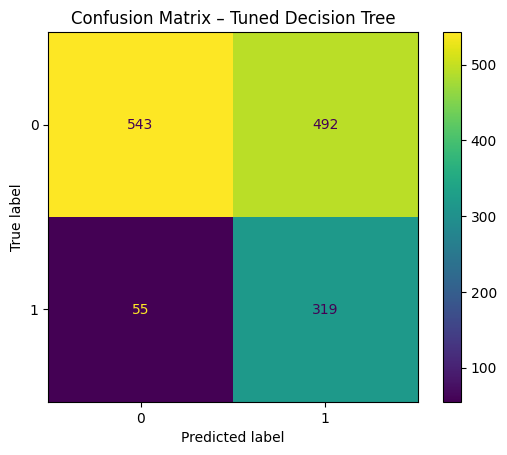

In [ ]:
dt_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", DecisionTreeClassifier(
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

dt_param_grid = {
    "model__criterion": ["gini", "entropy", "log_loss"],
    "model__splitter": ["best", "random"],
    "model__max_depth": [3, 5, 8, 12, 16],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5, 10, 20],
    "model__max_features": ["sqrt", "log2"],
    "model__ccp_alpha": [0.0, 1e-4, 1e-3, 1e-2],
}

dt_gs = GridSearchCV(
    estimator=dt_pipe,
    param_grid=dt_param_grid,
    scoring="recall",
    cv=skf,
    n_jobs=-1,
    refit=True,
)

dt_gs.fit(X_train, y_train)


best_dt = dt_gs.best_estimator_
y_pred = best_dt.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)

print("Decision Tree (tuned with CV)")
print("Best Recall:", dt_gs.best_score_)
print("Best params:", dt_gs.best_params_)
print()
print("Test scores")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1       :", f1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_dt.classes_)
disp.plot(values_format="d")
plt.title("Confusion Matrix – Tuned Decision Tree")
plt.show()


Decision Tree (final tuned model)
Accuracy : 0.6117814052519518
Precision: 0.3933415536374846
Recall   : 0.8529411764705882
F1       : 0.5383966244725739


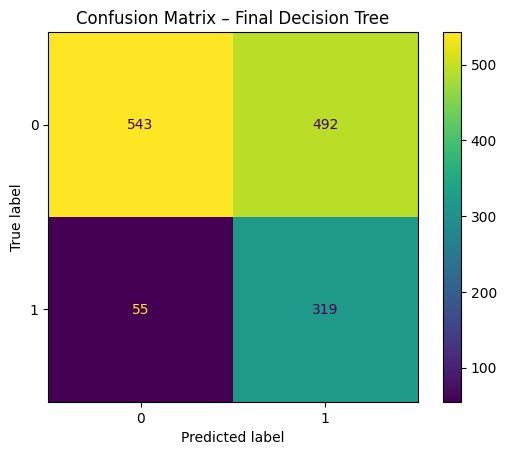

In [ ]:
dt_final = Pipeline([
    ("prep", preprocessor),
    ("model", DecisionTreeClassifier(
        ccp_alpha=0.0,
        criterion="gini",
        max_depth=3,
        max_features="sqrt",
        min_samples_leaf=1,
        min_samples_split=2,
        splitter="random",
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

dt_final.fit(X_train, y_train)
y_pred = dt_final.predict(X_test)

print("Decision Tree (final tuned model)")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1       :", f1_score(y_test, y_pred, zero_division=0))


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_final.classes_)
disp.plot(values_format="d")
plt.title("Confusion Matrix – Final Decision Tree")
plt.show()


Fitting 10 folds for each of 160 candidates, totalling 1600 fits
KNN (tuned with CV)
Best CV F1: 0.5960536912751678
Best params: {'model__leaf_size': 10, 'model__metric': 'minkowski', 'model__n_neighbors': 51, 'model__p': 2, 'model__weights': 'uniform'}

Test scores
Accuracy : 0.7842441447835344
Precision: 0.5906735751295337
Recall   : 0.6096256684491979
F1       : 0.6


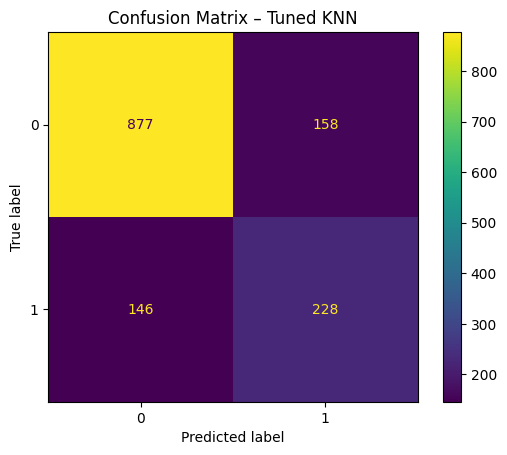

In [ ]:
knn_pipe = Pipeline([
    ("prep", preprocessor),
    ("scale", StandardScaler(with_mean=False)),
    ("model", KNeighborsClassifier())
])

knn_param_grid = {
    "model__n_neighbors": [3, 5, 7, 11, 15, 21, 31, 51],
    "model__weights": ["uniform", "distance"],
    "model__metric": ["minkowski"],
    "model__p": [1, 2],
    "model__leaf_size": [10, 20, 30, 40, 60],
}

knn_gs = GridSearchCV(
    estimator=knn_pipe,
    param_grid=knn_param_grid,
    scoring="recall",
    cv=skf,
    n_jobs=-1,
    refit=True,
    verbose=1
)

knn_gs.fit(X_train, y_train)

best_knn = knn_gs.best_estimator_
y_pred = best_knn.predict(X_test)

print("KNN (tuned with CV)")
print("Best CV F1:", knn_gs.best_score_)
print("Best params:", knn_gs.best_params_)
print()
print("Test scores")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1       :", f1_score(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn.classes_)
disp.plot(values_format="d")
plt.title("Confusion Matrix – Tuned KNN")
plt.show()


Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Naive Bayes (MultinomialNB, tuned with CV)
Best CV F1: 0.8642416107382551
Best params: {'model__alpha': np.float64(10.0), 'model__fit_prior': False}

Test scores
Accuracy : 0.6770759403832506
Precision: 0.4431977559607293
Recall   : 0.8449197860962567
F1       : 0.5814167433302668


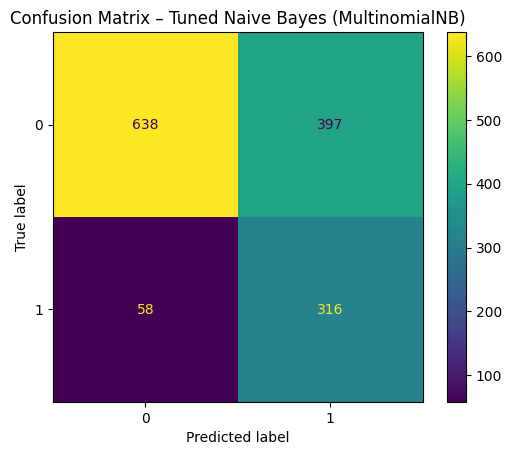

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB

mnb_preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler(feature_range=(0, 1)))
    ]), numeric_cols),
    ("cat", categorical_pipe, categorical_cols)
])

gnb_pipe = Pipeline([
    ("prep", preprocessor),
    ("dense", to_dense),
    ("model", GaussianNB())
])

mnb_pipe = Pipeline([
    ("prep", mnb_preprocessor),
    ("dense", to_dense),
    ("model", MultinomialNB())
])

gnb_grid = {
    "model__var_smoothing": np.logspace(-12, -6, 7)
}

mnb_grid = {
    "model__alpha": np.logspace(-4, 1, 10),
    "model__fit_prior": [True, False]
}

gnb_gs = GridSearchCV(gnb_pipe, gnb_grid, scoring="recall", cv=skf, n_jobs=-1, refit=True, verbose=1)
mnb_gs = GridSearchCV(mnb_pipe, mnb_grid, scoring="recall", cv=skf, n_jobs=-1, refit=True, verbose=1)

gnb_gs.fit(X_train, y_train)
mnb_gs.fit(X_train, y_train)

if gnb_gs.best_score_ >= mnb_gs.best_score_:
    best_gs = gnb_gs
    model_name = "GaussianNB"
else:
    best_gs = mnb_gs
    model_name = "MultinomialNB"

best_nb = best_gs.best_estimator_
y_pred = best_nb.predict(X_test)

print(f"Naive Bayes ({model_name}, tuned with CV)")
print("Best CV Recall:", best_gs.best_score_)
print("Best params:", best_gs.best_params_)
print()
print("Test scores")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1       :", f1_score(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_nb.classes_)
disp.plot(values_format="d")
plt.title(f"Confusion Matrix – Tuned Naive Bayes ({model_name})")
plt.show()


Naive Bayes (MultinomialNB + MinMaxScaler)
Accuracy : 0.6770759403832506
Precision: 0.4431977559607293
Recall   : 0.8449197860962567
F1       : 0.5814167433302668


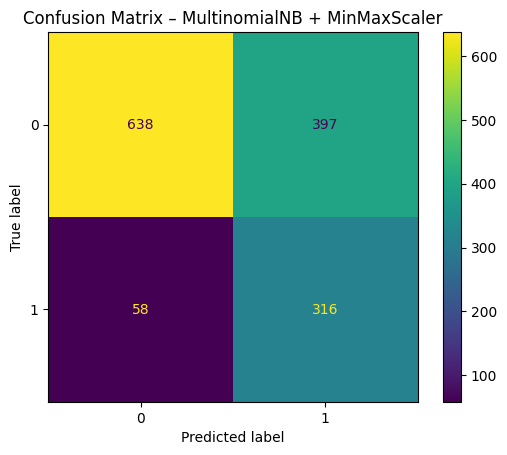

In [ ]:
nb_final = Pipeline([
    ("prep", preprocessor),
    ("nonneg", MinMaxScaler()),
    ("model", MultinomialNB(alpha=10.0, fit_prior=False))
])

nb_final.fit(X_train, y_train)
y_pred = nb_final.predict(X_test)

print("Naive Bayes (MultinomialNB + MinMaxScaler)")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1       :", f1_score(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_final.classes_)
disp.plot(values_format="d")
plt.title("Confusion Matrix – MultinomialNB + MinMaxScaler")
plt.show()


Fitting 10 folds for each of 63 candidates, totalling 630 fits
SVC (tuned with CV)
Best Recall: 0.8854944071588366
Best params: {'model__C': np.float64(0.1), 'model__gamma': np.float64(0.0001), 'model__kernel': 'rbf'}

Test scores
Accuracy : 0.5862313697657914
Precision: 0.38324022346368714
Recall   : 0.9171122994652406
F1       : 0.5405831363278172


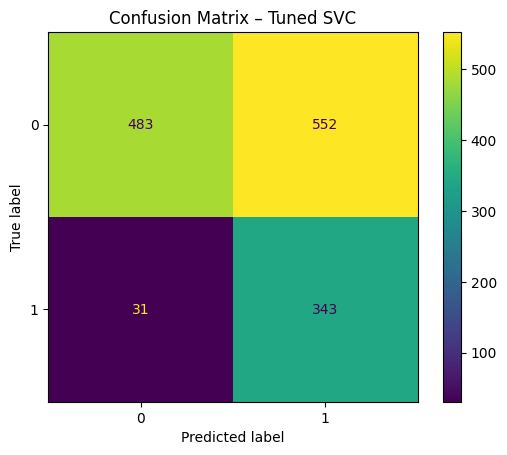

In [ ]:
svc_pipe = Pipeline([
    ("prep", preprocessor),
    ("scale", StandardScaler(with_mean=False)),
    ("model", SVC(class_weight="balanced", random_state=RANDOM_STATE))
])

svc_param_grid = [

    {
        "model__kernel": ["linear"],
        "model__C": np.logspace(-3, 3, 7),
    },

    {
        "model__kernel": ["rbf"],
        "model__C": np.logspace(-3, 3, 7),
        "model__gamma": ["scale", "auto"] + list(np.logspace(-4, 1, 6)),
    },
]

svc_gs = GridSearchCV(
    estimator=svc_pipe,
    param_grid=svc_param_grid,
    scoring="recall",
    cv=skf,
    n_jobs=-1,
    refit=True,
    verbose=1
)

svc_gs.fit(X_train, y_train)

best_svc = svc_gs.best_estimator_
y_pred = best_svc.predict(X_test)

print("SVC (tuned with CV)")
print("Best Recall:", svc_gs.best_score_)
print("Best params:", svc_gs.best_params_)
print()
print("Test scores")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1       :", f1_score(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svc.classes_)
disp.plot(values_format="d")
plt.title("Confusion Matrix – Tuned SVC")
plt.show()


SVC (final tuned model)
Accuracy : 0.5862313697657914
Precision: 0.38324022346368714
Recall   : 0.9171122994652406
F1       : 0.5405831363278172


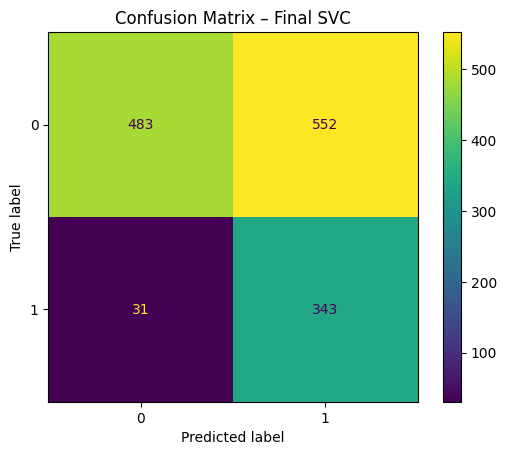

In [ ]:
svc_final = Pipeline([
    ("prep", preprocessor),
    ("scale", StandardScaler(with_mean=False)),
    ("model", SVC(
        C=0.1,
        gamma=0.0001,
        kernel="rbf",
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])


svc_final.fit(X_train, y_train)
y_pred = svc_final.predict(X_test)

print("SVC (final tuned model)")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1       :", f1_score(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_final.classes_)
disp.plot(values_format="d")
plt.title("Confusion Matrix – Final SVC")
plt.show()


## Ensembles

In [ ]:
rf = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        class_weight="balanced",
    ))
])

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Random Forest (baseline)")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1       :", f1_score(y_test, y_pred))


Random Forest (baseline)
Accuracy : 0.7700496806245565
Precision: 0.551440329218107
Recall   : 0.7165775401069518
F1       : 0.6232558139534884


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Random Forest (tuned with CV)
Best CV F1: 0.8227424749163879
Best params: {'model__max_depth': 3, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 800}

Test scores
Accuracy : 0.7139815471965933
Precision: 0.47665056360708535
Recall   : 0.7914438502673797
F1       : 0.5949748743718593


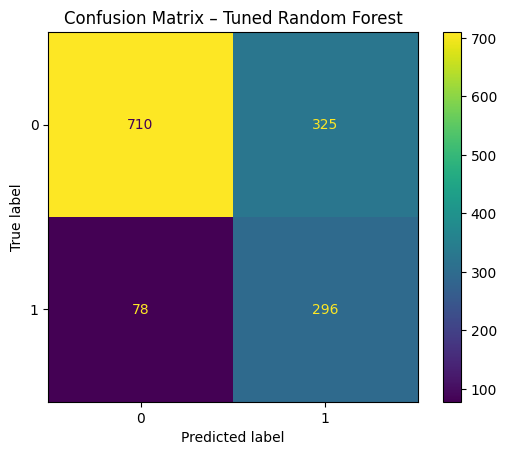

In [ ]:
rf_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1
    ))
])

rf_param_grid = {
    "model__n_estimators": [200, 300, 400, 800],
    "model__max_depth": [3, 5, 8],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5],
    "model__max_features": ["sqrt", "log2"],
}

rf_gs = GridSearchCV(
    estimator=rf_pipe,
    param_grid=rf_param_grid,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=3
)

rf_gs.fit(X_train, y_train)

best_rf = rf_gs.best_estimator_
y_pred = best_rf.predict(X_test)

print("Random Forest (tuned with CV)")
print("Best CV F1:", rf_gs.best_score_)
print("Best params:", rf_gs.best_params_)
print()
print("Test scores")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1       :", f1_score(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(values_format="d")
plt.title("Confusion Matrix – Tuned Random Forest")
plt.show()


Random Forest (final tuned model)
Accuracy : 0.7139815471965933
Precision: 0.47665056360708535
Recall   : 0.7914438502673797
F1       : 0.5949748743718593


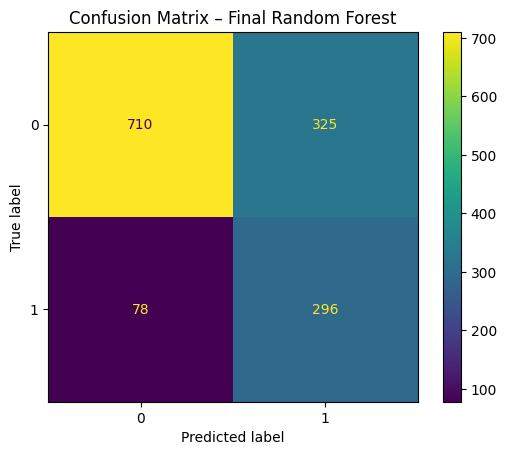

In [ ]:
rf_final = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=800,
        max_depth=3,
        max_features="log2",
        min_samples_leaf=1,
        min_samples_split=2,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])


rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_test)

print("Random Forest (final tuned model)")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1       :", f1_score(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_final.classes_)
disp.plot(values_format="d")
plt.title("Confusion Matrix – Final Random Forest")
plt.show()


In [81]:
from xgboost import XGBClassifier

xgb = Pipeline([
    ("prep", preprocessor),
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        eval_metric="logloss"
    ))
])

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("XGBoost (baseline)")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1       :", f1_score(y_test, y_pred))


XGBoost (baseline)
Accuracy : 0.7955997161107168
Precision: 0.6414473684210527
Recall   : 0.5213903743315508
F1       : 0.5752212389380531


In [ ]:
xgb_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method="hist"
    ))
])

xgb_param_grid = {
    "model__n_estimators": [200, 300, 400, 800],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 4, 6],
    "model__min_child_weight": [1, 5, 10],
    "model__subsample": [0.7, 0.85, 1.0],
    "model__colsample_bytree": [0.7, 0.85, 1.0],
}

xgb_gs = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=xgb_param_grid,
    scoring="recall",    
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=2
)

xgb_gs.fit(X_train, y_train)

print("Best CV Recall:", xgb_gs.best_score_)
print("Best params:")
print(xgb_gs.best_params_)


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best CV Recall: 0.537123745819398
Best params:
{'model__colsample_bytree': 1.0, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__min_child_weight': 5, 'model__n_estimators': 800, 'model__subsample': 0.7}


Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
XGBoost (tuned with CV)
Best CV Recall: 0.8207357859531774
Best params: {'model__colsample_bytree': 0.7, 'model__gamma': 0.5, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__min_child_weight': 5, 'model__n_estimators': 300, 'model__reg_lambda': 5.0, 'model__subsample': 1.0}

Test scores
Accuracy : 0.7452093683463449
Precision: 0.5126903553299492
Recall   : 0.8101604278074866
F1       : 0.627979274611399


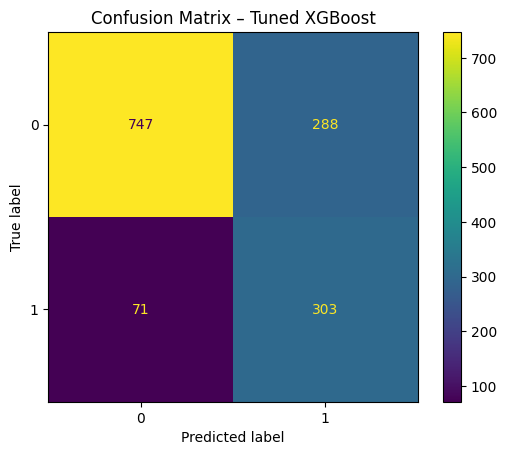

In [ ]:
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

xgb_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method="hist",
        scale_pos_weight=scale_pos_weight
    ))
])

xgb_param_grid = {
    "model__n_estimators": [300],
    "model__learning_rate": [0.01],
    "model__max_depth": [3, 4, 6, 8],
    "model__min_child_weight": [1, 3, 5],
    "model__subsample": [0.7, 0.85, 1.0],
    "model__colsample_bytree": [0.7, 0.85, 1.0],
    "model__gamma": [0, 0.5, 1.0, 2.0],
    "model__reg_lambda": [0.5, 1.0, 2.0, 5.0],
}

xgb_gs = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=xgb_param_grid,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=3
)

xgb_gs.fit(X_train, y_train)

best_xgb = xgb_gs.best_estimator_
y_pred = best_xgb.predict(X_test)

print("XGBoost (tuned with CV)")
print("Best CV Recall:", xgb_gs.best_score_)
print("Best params:", xgb_gs.best_params_)
print()
print("Test scores")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1       :", f1_score(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb.classes_)
disp.plot(values_format="d")
plt.title("Confusion Matrix – Tuned XGBoost")
plt.show()


Boosting – XGBoost (final tuned model)
Accuracy : 0.8034066713981547
Precision: 0.6947791164658634
Recall   : 0.4625668449197861
F1       : 0.5553772070626003


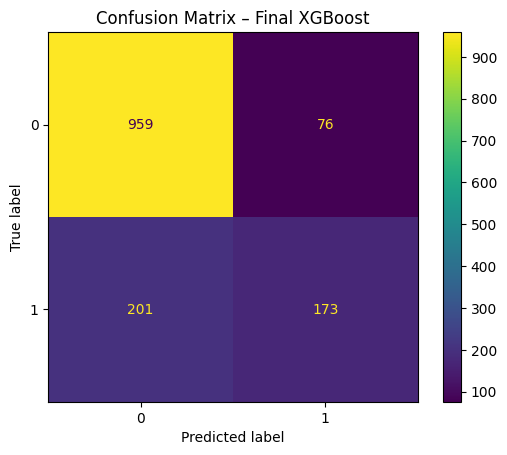

In [ ]:
xgb_final = Pipeline([
    ("prep", preprocessor),
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.01,
        max_depth=3,
        min_child_weight=5,
        gamma=0.5,
        colsample_bytree=0.7,
        subsample=1.0,
        reg_lambda=5.0,
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        n_jobs=-1,
        tree_method="hist"
    ))
])

xgb_final.fit(X_train, y_train)
y_pred = xgb_final.predict(X_test)

print("Boosting – XGBoost (final tuned model)")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1       :", f1_score(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_final.classes_)
disp.plot(values_format="d")
plt.title("Confusion Matrix – Final XGBoost")
plt.show()


In [ ]:
gs_model = xgb_gs.best_estimator_

y_pred_gs = gs_model.predict(X_test)
y_pred_final = xgb_final.predict(X_test)

print("Classes (GS):", gs_model.classes_)
print("Classes (Final):", xgb_final.classes_)
print("y_test unique:", np.unique(y_test))

print("\nPositive rate (GS):", np.mean(y_pred_gs == 1))
print("Positive rate (Final):", np.mean(y_pred_final == 1))

print("\nConfusion matrix (GS):\n", confusion_matrix(y_test, y_pred_gs))
print("\nConfusion matrix (Final):\n", confusion_matrix(y_test, y_pred_final))


Classes (GS): [0 1]
Classes (Final): [0 1]
y_test unique: [0 1]

Positive rate (GS): 0.41944641589779985
Positive rate (Final): 0.1767210787792761

Confusion matrix (GS):
 [[747 288]
 [ 71 303]]

Confusion matrix (Final):
 [[959  76]
 [201 173]]


In [ ]:
y_proba = xgb_final.predict_proba(X_test)[:, 1]

y_pred_recall = (y_proba >= 0.25).astype(int)

print("Recall:", recall_score(y_test, y_pred_recall))
print("Precision:", precision_score(y_test, y_pred_recall, zero_division=0))


Recall: 0.8181818181818182
Precision: 0.4967532467532468


In [ ]:
import joblib

joblib.dump(logreg, "logreg.pkl")
joblib.dump(svc, "svc.pkl")
joblib.dump(gnb, "gaussian_naive_bayes.pkl")
joblib.dump(dt, "decision_tree.pkl")

joblib.dump(logreg_final, "logreg_final.pkl")
joblib.dump(svc_final, "svc_final.pkl")
joblib.dump(nb_final, "gaussian_naive_bayes_final.pkl")
joblib.dump(dt_final, "decision_tree_final.pkl")

['decision_tree_final.pkl']

In [100]:
joblib.dump(rf, "random_forest.pkl")
joblib.dump(rf_final, "random_forest_final.pkl")


['random_forest_final.pkl']

In [101]:
joblib.dump(xgb, "xgboost.pkl")
joblib.dump(xgb_final, "xgboost_final.pkl")

['xgboost_final.pkl']

In [ ]:
np.save("X_train_preprocessed.npy", X_train)
np.save("X_test_preprocessed.npy", X_test)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)
joblib.dump(preprocessor, "preprocessor.pkl")

['preprocessor.pkl']